### Load the Libraries
The libraries are imported. It can be seen that a new library called __'gym'__ is loaded. This is to provide an __interface__ for the game. It can be thought of as a video game taking input __action__ by the user and giving out the __next state__ of the system so that the user gets the information of the new state and plays accordingly by takeing a new action.

<img width="320" height="240" src="Image/2.gif" >

In [7]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Decide the number of times the AI system must play the game.
This describes the number of episodes to train the model. The episodes can be thought of as the number of times the model plays the game. Here the system is the Cartpole Problem.

In [8]:
EPISODES = 800
print ('Total Number of Episodes :' + str(EPISODES))

Total Number of Episodes :800


### Make a class named "Agent" to represent various function, methods and variables.
#### Different Element of the Class:
1. init or the initialiser 
   >This will initiasise the parameters of the class including the 
    - gamma : the discount rate. This takes care that future rewards which can come over time are weigted. For example if an action taken at this state can lead to some future reward then this future reward is weigted by gamma and added to the total reward at this state. This is called the discounted future reward. In real world one can think this discounted future reward as measuring the Quality of the action taken at any moment of the game.
    - epsilon : the exploration rate of the model. The rate at which the agent will explore new actions against the predicted best action at that state. This can be thought of as a player trying to try new action just to find out if it works.
    -epsilon decay : As the model learns to play the game with episodes the agent need to rely on the model and thus the exploration rate must be decreased. This can be compared to the style a player develops. Once developed the players starts playing in that way and seldom tries new ways
    -learning rate- The learning rate of the model is the steps the deep learning network takes to learn the weights. The input to the model is the state of the environment and the output is the action the model must take in that state. This model can be imagines as a table which gives the best action to be taken at the state the environment returns.
2. build model
    >This will build the deep network which will learn the Q function.
3. Replay memory
    >This basically helps to add new sets of __(state, action, reward, next_state, done)__ to memory as the agent plays the game. This is inspired by the fact that human memory replays in sleep to learn something. In a more practical way this can thought as the agent making note of the set it experience and replays it after it has gather sufficient such memories. This helps in efficient learning.
4. act
    >This fuction takes an action based on the state the environment renders. This either takes 
    - a random action or 
    - an action predicted by the model. These two are controled according to the epsilon value. This is where the models explore new states and solves the Exploitation- Exploration Problem of the player.
5. replay
    >Here the model is trained with minibatches stored in the replay memory. The input is the state and the output is the Q values already predicted by the model. You would think why does the model trains itself on what it can predict. You are correct! There is a small twist. Here the predicted Q value corresponding to the action taken in the state is changed according to the bellmen equation, thus helping the model to learn the quality of the action based on the future reward it can expect by obsetving the next state the environment returned. This can be though of as a chess player evaluating himself after the game is over by considering the action taken at any step and the consequence of the action at that step which is the opponents next move. If the opponents next move gave the player a pawn he would add this reward back to the action he took in the previous step.
     - state : This is the current state of the model
     - target_f : The row of the Q-matrix corresponding to the current state. In this the Q-value of action-state pair is changed according to the bellmen equation.
     <img src="Image/1.png" width="400" length="700">

In [10]:

class Agent:
    
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95          # Discount rate
        self.epsilon = .8          # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = .998  # Rate at which the epsilon will decay. Exploration- Exploitation problem.
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        return model

    def remember(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))

    
    def act(self, state):
        
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)   # Random action
        act_values = self.model.predict(state)          # Models predicted action 
        return np.argmax(act_values[0])                 # Returns action

    
    def replay(self, batch_size):
        
        # Make a minibatch by random selection from the memory.
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            #     If the game is not over then the reward will be the discounted future reward given by the Bellmen Equation.
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            #     If the game is over then the reward will be the immediate reward at that step.
            else: target = reward

            target_f = self.model.predict(state)
            #     Here the target value corresponding to a action which was taken is changed is changed.
            target_f[0][action] = target
            
            #     Now this is passed to the model so that it can learn by backpropagating the Error.
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        #    This step decreases the value of epsilon with the progression of training to reduce exploration by 
        #    multiplying it with the decay rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### Make environment for the Cartpole problem
Make an environment and set the state size and the action size. Also make an object of the class Agent. This will be the player of our game.

1. State Size of the problem - The state of the cartpole is represented by a state which includes:__[position of cart, velocity of cart, angle of pole, rotation rate of pole]__Hence for the cartpole problem the state_size is 4. Maybe in other game like mario the state size can be four consecutive srcreens just before the current screen. This may give important information of velocity of mario, velocity of the obstacles, position of the obstackles etc. 
2. The action of the cartpole can be:__[push the cart to left, push the cart to right]__.Hence the action_size will be 2 in that case. In case of a chess player playing a game the action size may be large enough and may change with time(For example a pawn dies or the knight cannot move as it is surrounded, the action size reduces).

In [11]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]

action_size = env.action_space.n

agent = Agent(state_size, action_size)

[2018-01-02 04:22:45,403] Making new env: CartPole-v1


## Run the model to estimate the Q Function using the Deep Learning Model(Deep Q Network)
Here the network is run. First the agent takes an action based on its functions(Either random or predicted by the model- controlled by the epsilon value). Next the environment responds by giving back a new state(can be thought of as the opponents move). The agent takes the __current state, action, reward, the next_state, done status(1= game over, 0= game not over)__ and stores it in its memory(can be though of as the chess player writing his log). These steps are repeated untill the game gets over ( or time 500 whichever is lower ). After the game gets over the agent starts to play again for the second episode. However before starting the next game the agent checks if it has sufficient memory(can be thought of as the chess player checking if he has 2(his wish maybe 3) pages of log and starts to analyse his game). If it has enough examples it randomly samples few of them and goes on for an experience replay(model training) and after it does its homework it returns back to the for loop to play the game in a much better way. This cycle is repeated until the network has learned a good game.

In [7]:
episode= []

#Set this to false as initially the model must think the game is not over untill and unless the env says so.
done = False

#Set the batch size of the minibatch for the training of the deepQModel.
batch_size = 32
print ('Batch size: '+ str(batch_size))

#Show the architecture of the model
print ('The summary of the model')
agent.model.summary()
#Run the iterations for the number of predefined Episodes. Each episode is the time between game start and end.
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        #env.render()
        
        #Deciding the action to be taken for the above rendered state.
        action = agent.act(state)
        
        #The environments response to the action taken by the model in the above step.
        next_state, reward, done, _ = env.step(action)
        
        #The reward will be -10 if the cartpole falls and the game ends.
        reward = reward if not done else -10
        
        next_state = np.reshape(next_state, [1, state_size])
        
        #The data of every time step is added to the memory for training after the episode terminates.
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        if done:
            if (e%20==0) :
                print("episode: {}/{}, score: {}, e: {:.2}"
                        .format(e, EPISODES, time, agent.epsilon))
                
            episode.append(time)
            break
            
    #After a single game is done(or after every episode), the model trains itself with the data stored in the 
    #memory by first checking if it has sufficient memory.
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

episode: 0/800, score: 163, e: 0.45
episode: 20/800, score: 123, e: 0.43
episode: 40/800, score: 58, e: 0.41
episode: 60/800, score: 29, e: 0.4
episode: 80/800, score: 188, e: 0.38
episode: 100/800, score: 276, e: 0.37
episode: 120/800, score: 22, e: 0.35
episode: 140/800, score: 176, e: 0.34
episode: 160/800, score: 95, e: 0.32
episode: 180/800, score: 293, e: 0.31
episode: 200/800, score: 137, e: 0.3
episode: 220/800, score: 143, e: 0.29
episode: 240/800, score: 209, e: 0.28
episode: 260/800, score: 499, e: 0.27
episode: 280/800, score: 495, e: 0.26
episode: 300/800, score: 238, e: 0.25
episode: 320/800, score: 285, e: 0.24
episode: 340/800, score: 360, e: 0.23
episode: 360/800, score: 167, e: 0.22
episode: 380/800, score: 499, e: 0.21
episode: 400/800, score: 421, e: 0.2
episode: 420/800, score: 174, e: 0.19
episode: 440/800, score: 16, e: 0.19
episode: 460/800, score: 18, e: 0.18
episode: 480/800, score: 186, e: 0.17
episode: 500/800, score: 188, e: 0.16
episode: 520/800, score: 20

### Print the score of the model as a graph for visualisation.

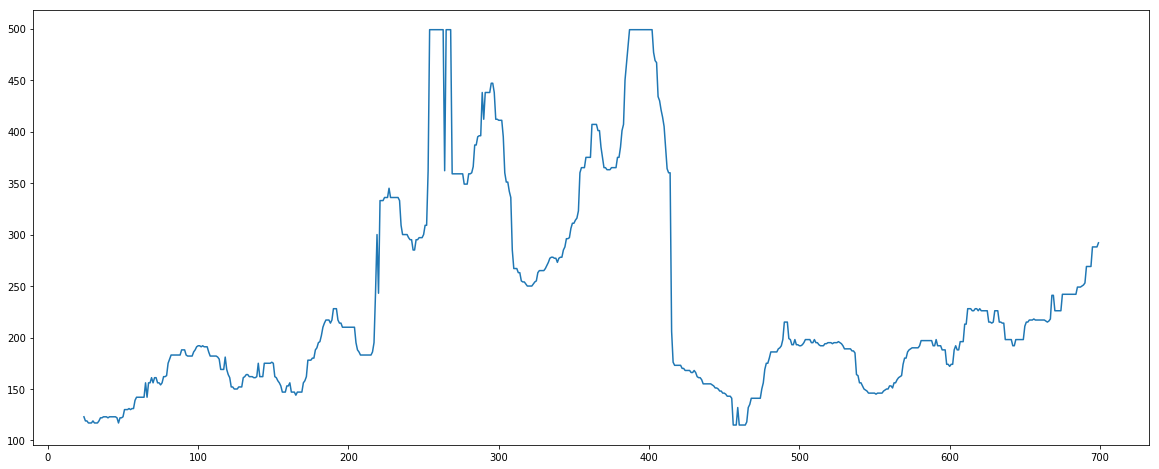

In [8]:
episode= pd.DataFrame(episode[:700])
episode= pd.rolling_median(episode, 25)
plt.figure(figsize=(20,8))
plt.plot(episode)
plt.show()